In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [151]:
# For hotspot analysis and clustering 
import libpysal as lps
from libpysal.weights import Voronoi
from sklearn.preprocessing import StandardScaler
from esda.moran import Moran, Moran_Local
from sklearn.cluster import DBSCAN


In [50]:
# For visualisation

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl
import branca.colormap
import folium
from IPython.display import IFrame
from IPython.display import display
from folium.plugins import HeatMap

plt.style.use('seaborn-whitegrid')

In [3]:
# Put here the path where the definitions are saved
import sys
sys.path.insert(0, r'C:\Users\demdr\UTS\Important files for PhD thesis\Definitions')

from definitions_for_reading_density_and_node_maps import construct_KDTree,find_closest_node, find_closest_nodes

#### Import a csv which has the data from all the participants combined 

In [135]:
# Import the data that will be processed for the cluster analysis 
# ATTENTION: After applying the algorithms of the 1st component for more than 1 participant, 
# we should combine the resulting dataframes 
# (the 'fusion_df' created from the file 'Step 3 - Physiological, movement and contextual data fusion')
# in one dataframe that has all data from all participants. This step is NOT included here and should be conducted before
# (simply by importing the analysed csv files from all participants and concatenating them)
# The combined dataset should be then used here as the input.


# Put the path of this file (the combined dataset) below
path_to_read = r'xxxxxxx'

#Path that I used in my experiments: 
path_to_read = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Analysed data\Combined data from all participants.csv'
df_for_analysis = pd.read_csv(path_to_read)
df_for_analysis.index = df_for_analysis['Datetime']
df_for_analysis.index = pd.to_datetime(df_for_analysis.index, utc=True).tz_convert('Australia/Sydney')

In [136]:
df_for_analysis = df_for_analysis[df_for_analysis['Outdoor UTS']==0]

#### Resample the df in the desired frequency 

In [144]:
# Now it is resampled at 10 seconds but we can change that

resampling_freq = '10S'
resampled_final = pd.DataFrame()



for user in df_for_analysis['UserID'].unique():
    this_session = df_for_analysis[df_for_analysis['UserID']==user].copy()
    for ses in this_session['Session'].unique():
        this_subdf = this_session[this_session['Session']==ses].copy()
        this_subdf.index = pd.to_datetime(this_subdf.index, utc=False)
        resampled = this_subdf.resample(resampling_freq).mean()
        resampled['Session']=this_subdf['Session'][0]
        resampled_final = resampled_final.append(resampled[:resampled.index[-1]])

In [146]:
# Create a new df that we will use
cluster_df = resampled_final.fillna(0).copy()
cluster_df['Sum of EDR amplitudes_change']=cluster_df['Significant Changes:Sum of EDR amplitudes'].copy()
cluster_df = cluster_df.fillna(0)


In [150]:
if 'Sum of EDR amplitudes' not in cluster_df.columns:
    cluster_df['Sum of EDR amplitudes']=cluster_df['Sum of EDA amplitudes'].copy()

#### Create weights for calculation of the Local Moran's I

In [158]:
# remove errors in coordinate if present 
cluster_df = cluster_df[(cluster_df['Latitude']!=0)&(cluster_df['Longitude']!=0)]
coords = list(zip(cluster_df['Latitude'],cluster_df['Longitude']))
scaler = StandardScaler()
transformed_coords = scaler.fit_transform(coords)


#### Create the matrix of spatial weights

In [159]:
spatial_weights_matrix = Voronoi(transformed_coords)

#### Create an array that stores the userID for each row of the df

In [160]:
user_array = np.array(cluster_df['UserID'].values)

#### Apply a cutoff to remove high values in the signal if needed
Here we can try different cutoffs:
- 0.7 for  change in sum of EDR amplitudes (modify this if needed)
- No cutoff for sum of EDR amplitudes
The cutoffs act as thresholds. The data points which have values above the threshold will be overwritten with the threshold value instead (so that the threshold value is the max value in the change in sum of EDR amplitudes)


In [186]:
def apply_cutoff_for_outliers(this_df, signal_name, high_cutoff_val, low_cutoff_val):
    new_col_name = signal_name + '_after_cutoff'
    this_df[new_col_name]=this_df[signal_name].copy()
    this_df.loc[this_df[this_df[signal_name]>high_cutoff_val].index, new_col_name]=high_cutoff_val
    this_df.loc[this_df[this_df[signal_name]<low_cutoff_val].index, new_col_name]=low_cutoff_val
    return(this_df)

In [187]:
# Apply the cutoff definition: Put here the name of the column of the signal that we are analysing 
target_signal = 'Sum of EDR amplitudes_change'
# The threshold values for this function were chosen after experimentation
# Modify them if needed 
cluster_df = apply_cutoff_for_outliers(cluster_df, target_signal, 0.7, -0.7)
# If we do not want to put cutoff values, use this instead:
# cluster_df = apply_cutoff_for_outliers(cluster_df, target_signal, cluster_df[target_signal].max(), cluster_df[target_signal].min())


# Repeat for the other signals: Sum of EDR amplitudes
target_signal = 'Sum of EDR amplitudes'
#copy_df = cluster_df.copy()

cluster_df = apply_cutoff_for_outliers(cluster_df, target_signal, cluster_df[target_signal].max(), cluster_df[target_signal].min())

In [189]:
def construct_lag_values(this_df, target_signal, this_weights_matrix):
    lag_values = lps.weights.lag_spatial(this_weights_matrix, this_df[target_signal].values)
    
    return(lag_values)

In [166]:
# Activate this to apply the definition above if needed
'''
lag_values_sumofEDRamplitudes = construct_lag_values(cluster_df, 'Sum of EDR amplitudes_after_cutoff',spatial_weights_matrix)
# The following var replaced this: change_EDR_lag
lag_values_changeinsumofEDRamplitudes = construct_lag_values(cluster_df, 'Sum of EDR amplitudes_change_after_cutoff',spatial_weights_matrix)
'''

#### Calculate Local Moran's I values
- First for changes in EDR
- Then for continuous Sum of EDR

In [168]:
def find_hotspots(this_df, target_signal, this_weight_matrix):

    local_moran_values = Moran_Local(this_df[target_signal].values, this_weight_matrix)
    hotspot_stress = this_df.loc[this_df.index[np.where((local_moran_values.p_sim<0.05) & (local_moran_values.q==1))]]
    hotspot_stress = hotspot_stress[hotspot_stress[target_signal]>0]
    coldspot_stress = this_df.loc[this_df.index[np.where((local_moran_values.p_sim<0.05) & (local_moran_values.q==3))]] 
    
    # The columns 'Local Moran_Sum of EDR amplitudes' and 'Local Moran_Sum of EDR amplitudes_change' should be created from this line: 
    new_col_name = 'Local Moran_' + target_signal.replace('_after_cutoff','')
    print('new column created:', new_col_name)
    cluster_df[new_col_name]=0
    cluster_df.loc[hotspot_stress.index, new_col_name]=2
    cluster_df.loc[coldspot_stress.index, new_col_name]=1
    return(cluster_df)



In [190]:
# Apply definition for calculating the Local Moran's I values

cluster_df = find_hotspots(cluster_df, 'Sum of EDR amplitudes_after_cutoff',spatial_weights_matrix)
cluster_df = find_hotspots(cluster_df, 'Sum of EDR amplitudes_change_after_cutoff',spatial_weights_matrix)

new column created: Local Moran_Sum of EDR amplitudes
new column created: Local Moran_Sum of EDR amplitudes_change


#### Visualise the hotspots 
This definition creates a map as a html object, displaying the hotspots

- The 'step' is used to control how many non-hotspot points will be displayed. 
- ALL the hotspot points will be displayed; only the ones that do not belong in hotspots will be displayed at a lower resolution in this way.
- Step=5 indicates that every 5 values, only 1 will be displayed and the other 4 will be skipped 
- NH_opacity is the opacity of the points that do not belong in hotspots
- NH radius is the radius of these points 
- H_opacity and H_radius are the opacity and the radius values for the points in hotspots

In [191]:
def create_map_to_visualise_hotspots(this_df, target_signal, map_name, step,NH_opacity,NH_radius,H_opacity,H_radius):
    this_map = folium.Map(location = [-33.883217, 151.200881], zoom_start = 20, tiles='CartoDB positron' ) 
    map_title = map_name + '.html'
    this_map.save(map_title)

    
    
    colour_map_steps = 10
    #The YlOrRd_09 colormap is used for points which DO belong in a hotspot
    colormap = branca.colormap.linear.YlOrRd_09.scale(0.0, 1).to_step(colour_map_steps)
    gradient_map=defaultdict(dict)
    for i in range(colour_map_steps):
        gradient_map[1/colour_map_steps*i] = colormap.rgb_hex_str(1/colour_map_steps*i)
    gmap=gradient_map

    #The viridis colormap is used for points which DO NOT belong in a hotspot
    colormap2 = branca.colormap.linear.viridis.scale(0.0, 1).to_step(colour_map_steps)
    gradient_map2=defaultdict(dict)
    for i in range(colour_map_steps):
        gradient_map2[1/colour_map_steps*i] = colormap2.rgb_hex_str(1/colour_map_steps*i)
    gmap2=gradient_map2


    # Visualise the points which ARE NOT in hotspots
    for i in range(0,len(coords[::step])):
        c = coords[::step][i]
        this_pt = (coords[::step][i][0],coords[::step][i][1])
        user = user_array[::step][i]
        hotspot_pts = cluster_df[target_signal].values[::step][i]
        if hotspot_pts!=2:
            # put the most intense colour of the colour map for the non-hotspot points
            this_colour=gmap2[1/colour_map_steps*9]
            this_opacity = NH_opacity
            this_radius=NH_radius
            # The following line creates the points that DO NOT belong in hotspots
            folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                            radius=this_radius, opacity=this_opacity,
                   popup = str(user)).add_to(this_map)


    # Visualise the points which ARE in hotspots
    for i in range(0,len(coords[::])):
        c = coords[::][i]
        this_pt = (coords[::][i][0],coords[::][i][1])
        user = user_array[::][i]
        hotspot_pts = cluster_df[target_signal].values[::][i]
        if hotspot_pts==2:
            # put the most intense colour of the colour map for the hotspot points
            this_colour = gmap[1/colour_map_steps*9]
            this_opacity = H_opacity
            this_radius = H_radius
            # The following line creates the points that belong in hotspots
            # If a point is clicked, the user ID is displayed. If we don't want that, then the 'popup=str(user)'
            # should be deleted
            folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                            radius=this_radius, opacity=this_opacity,
                   popup = str(user)).add_to(this_map)


    
    # Create a heatmap that contains only the points that are in hotspots
    # We do this to emphasise the hotspot locations graphically
    HeatMap(data=this_df[this_df[target_signal]==2][['Latitude', 'Longitude', target_signal]].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),gradient=gmap, radius=6.5, max_zoom=13).add_to(this_map)


    this_map.save(map_title)
    

In [192]:
# Apply the definition to visualise the hotspots: 
title = 'HOTSPOTS_Change in sum of EDR amplitudes'
display_title = './' + title + '.html'
#this_NH_opacity,this_NH_radius: opacity and radius for non-hotspot points
#this_H_opacity,this_H_radius: opacity and radius for hotspot points
this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 0.1
create_hotspot_map1 = create_map_to_visualise_hotspots(cluster_df, 'Local Moran_Sum of EDR amplitudes_change', title, 5,
                                                       this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius)
IFrame(src=display_title, width=1500, height=1500)

In [193]:
title = 'HOTSPOTS_Sum of EDR amplitudes'
# Create the map
this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 0.1
create_hotspot_map1 = create_map_to_visualise_hotspots(cluster_df,'Local Moran_Sum of EDR amplitudes', title, 5,
                                                      this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius)
# Display the created map 
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

## Betweenness analysis for estimation of pedestrian activity

#### Import the dataframe containing the results of the betweenness centrality analysis 

In [194]:
node_centrality_df = r'CCCCCC' # put here the appropriate path, ending in .csv
#Path that I used for my experiments:
#node_centrality_df = pd.read_csv(r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Centrality measures.csv')

#### construct kd-tree containing the street network nodes of the csv with the betweenness centrality data

In [195]:
node_KDtree = construct_KDTree(node_centrality_df, 'Latitude','Longitude')

In [196]:
# Also reindex the file because some users travelled at the same time and have the same timestamp-based index 
cluster_df['Datetime']=cluster_df.index.copy()
cluster_df.index = np.arange(len(cluster_df))

#### Find which points have a high betweenness and belong in EDR or HR hotspots

In [197]:
def rate_points_based_on_betweenness_centrality(this_df, target_signal):
    # This is the name of the new column that we are creating, to store the betweenness value of each point
    new_col_name = 'High betweenness_' + target_signal
    # This is the name of the column that has the points which belong to hotspots 
    # i.e. 'Local Moran_Sum of EDR amplitudes_change'
    hotspot_col = 'Local Moran_' + target_signal
    
    
    
    this_df[new_col_name]=0
    hotspot_index = this_df[this_df[hotspot_col]==2].index
    for i in hotspot_index:
        this_pt = [this_df.loc[i, 'Latitude'],this_df.loc[i,'Longitude']]
        
        # Find 5 closest points and get their betweenness
        closest_nodes = find_closest_nodes(node_KDtree, this_pt[0],this_pt[1], 5)
        this_betweenness = 0
        for arr in closest_nodes[1]:
            neighbourhood_betweenness = []
            this_node_indexes = arr
            for c in this_node_indexes:
                this_node_index = c
                this_node_btns = node_centrality_df.loc[node_centrality_df.index[this_node_index], 'betweenness_centrality'].mean()
                neighbourhood_betweenness.append(this_node_btns)
            this_betweenness = np.mean(np.array(neighbourhood_betweenness))

        
        # The points are ranked based on the betweenness 
        # The ranks are based on the mean and std values of the betweenness centrality data 
        # mean_btn is the mean betweenness and std_btn is the std of the betweenness centrality data
        # The rank has values from 0 to 2 (0,0.5,1,1.5,2)
        mean_btn = node_centrality_df['betweenness_centrality'].mean()
        std_btn = node_centrality_df['betweenness_centrality'].std()
        
        if this_betweenness>=mean_btn + 1*std_btn:
            this_df.loc[i, new_col_name]=0.5
        if this_betweenness>=mean_btn + 2*std_btn:
            this_df.loc[i, new_col_name]=1
        if this_betweenness>=mean_btn + 3*std_btn:
            this_df.loc[i, new_col_name]=1.5
        if this_betweenness>=mean_btn + 4*std_btn:
            this_df.loc[i, new_col_name]=2
    
    return(this_df)

#### Apply algorithm for ranking points based on betweenness 
This part creates a new column (for each signal that we analyse) which process the hotspot points and rank them based on the betweenness centrality of their closest network nodes. 

The new column is called 'High betweenness_....' where ... is the rest of the signal

(i.e. 'High betweenness_Sum of EDR amplitudes')

In [198]:
cluster_df = rate_points_based_on_betweenness_centrality(cluster_df, 'Sum of EDR amplitudes_change')
cluster_df = rate_points_based_on_betweenness_centrality(cluster_df, 'Sum of EDR amplitudes')

## Visualise the ranking of hotspot points based on betweenness

In [199]:
def visualise_betweenness_ranking(this_df, target_signal, map_name, step, NH_opacity,NH_radius,H_opacity,H_radius):

    this_map = folium.Map(location = [-33.883217, 151.200881], zoom_start = 20, tiles='CartoDB positron' ) 
    map_title = map_name + '.html'
    this_map.save(map_title)
    col_name = 'High betweenness_' + target_signal
    hotspot_col_name = 'Local Moran_' + target_signal
    betweenness_array = np.array(this_df[col_name])
    
    
    
    steps = 10
    colormap = branca.colormap.linear.YlOrRd_09.scale(0.0, 1).to_step(steps)
    gradient_map=defaultdict(dict)
    for i in range(steps):
        gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
    gmap=gradient_map

    colormap2 = branca.colormap.linear.viridis.scale(0.0, 1).to_step(steps)
    gradient_map2=defaultdict(dict)
    for i in range(steps):
        gradient_map2[1/steps*i] = colormap2.rgb_hex_str(1/steps*i)
    gmap2=gradient_map2

    
    # Visualise the points that do not belong to hotspots, with another colour 
    for i in range(0,len(coords[::step])):
        c = coords[::step][i]
        this_pt = (coords[::step][i][0],coords[::step][i][1])
        user = user_array[::step][i]
        hotspot_pts = this_df[hotspot_col_name].values[::step][i]
        if hotspot_pts!=2:
            this_colour=gmap2[1/steps*9]
            this_opacity = NH_opacity
            this_radius=NH_radius
            folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                            radius=this_radius, opacity=this_opacity
                   ).add_to(this_map)
    


    # Visualise the points that belong to hotspots 
    for i in range(0,len(coords[::])):
        c = coords[::][i]
        this_pt = (coords[::][i][0],coords[::][i][1])
        
        user = user_array[::][i]
        this_betweenness = betweenness_array[::][i]
        hotspot_pts = cluster_df[hotspot_col_name].values[::][i]
        if hotspot_pts==2:
            this_colour = gmap[1/steps*6]
            this_opacity = H_opacity
            this_radius = H_radius

            if this_betweenness==0.5:
                this_radius = H_radius*2
                this_colour = gmap[1/steps*6]
                this_opacity = H_opacity

            if this_betweenness==1:
                this_radius = H_radius*4
                this_colour = gmap[1/steps*7]
                this_opacity = H_opacity

            if this_betweenness==1.5:
                this_radius = H_radius*6
                this_colour = gmap[1/steps*8]
                this_opacity = H_opacity


            if this_betweenness==2:
                this_radius = H_radius*8
                this_colour = gmap[1/steps*9]
                this_opacity = H_opacity


            folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                            radius=this_radius, opacity=this_opacity, fill_opacity = this_opacity,
                   popup = str(this_betweenness)).add_to(this_map)


    # Activate this to add a heatmap for the hotspot points
    #HeatMap(data=this_df[this_df[hotspot_col_name]==2][['Latitude', 'Longitude', hotspot_col_name]].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),gradient=gmap, 
            #radius=9, max_zoom=13).add_to(this_map)

    this_map.save(map_title)



#### Use the definition to colour the trajectory points according to betweenness for the clusters of changes in sum of EDR amplitudes

In [200]:
title = 'Visualise betweenness analysis for trajectory points-Changes in sum of EDR amplitudes'
this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_betweenness_map1 = visualise_betweenness_ranking(cluster_df, 'Sum of EDR amplitudes_change', title, 5, 
                                                       this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius)
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to colour the trajectory points according to betweenness for the clusters of  for the sum of EDR amplitudes

In [201]:
# Use the definition to visualise the betweenness for the sum of EDR amplitudes

title = 'Visualise betweenness analysis for trajectory points-sum of EDR amplitudes'
this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_betweenness_map1 = visualise_betweenness_ranking(cluster_df, 'Sum of EDR amplitudes', title, 5, 
                                                       this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius)
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

# Create clusters based on distance, and put this information in the df
These clusters contain only the points which have already been identified as significant based on the local moran I

In [203]:
def create_clusters_with_DBSCAN(this_df, target_signal):
    col_name = 'Local Moran_' + target_signal
    #The name of a new column where we are going to store the cluster labels
    cluster_col_name = target_signal + '_cluster_label'
    hotspot_df = this_df[this_df[col_name]==2]
    this_df[cluster_col_name] = 0
    if len(hotspot_df)>0:
        hotspot_coords = list(zip(hotspot_df['Latitude'],hotspot_df['Longitude']))
        dbscan_clusters = DBSCAN(eps=0.0003, algorithm='kd_tree', min_samples=10).fit(hotspot_coords)

        cluster_labels = dbscan_clusters.labels_
        cluster_labels = np.add(cluster_labels,2)
        cluster_labels


        # Put the resulting clusters in the df 
        #this array has the indices of df points where there are hotspots
        # It has the same size as the array 'cluster_labels'
        hotspot_points_array = np.where(this_df[col_name].values==2)
        #create a new column to store the cluster labels
        for i in range(0, len(hotspot_points_array[0])):
            # get the index of each hotspot point
            this_index = hotspot_points_array[0][i]
            # get the cluster label corresponding to each hotspot point and store it in the df
            this_df.loc[this_df.index[this_index], cluster_col_name]=cluster_labels[i]
    return(this_df)

#### Apply the algorithm for cluster creation with DBSCAN

In [204]:
cluster_df = create_clusters_with_DBSCAN(cluster_df, 'Sum of EDR amplitudes_change')
cluster_df = create_clusters_with_DBSCAN(cluster_df, 'Sum of EDR amplitudes')

#### Find the number of clusters for the selected signal 

In [205]:
def print_number_of_clusters(this_df, target_signal):
    cluster_col_name = target_signal + '_cluster_label'
    print('number of clusters for signal ', target_signal, ': ', len(this_df[cluster_col_name].unique()))


In [206]:
print_number_of_clusters(cluster_df, 'Sum of EDR amplitudes')
print_number_of_clusters(cluster_df, 'Sum of EDR amplitudes_change')

number of clusters for signal  Sum of EDR amplitudes :  63
number of clusters for signal  Sum of EDR amplitudes_change :  65


## Cluster ranking systems

#### User-based ranking
- Count the number of users for each cluster
- Print this information 
- Also store it in the df 
- The next definition can then be used for selecting the data points belonging to clusters with many users

In [207]:
def count_users_in_each_cluster(this_df, target_signal):
    cluster_col_name = target_signal + '_cluster_label'
    signal_col_name = target_signal + '_after_cutoff'
    user_col_name = 'Number of users_' + target_signal
    
    
    cluster_users = []
    cluster_points = []
    print('num of clusters for ', target_signal, ' signal:', len(this_df[cluster_col_name].unique())-1)
    this_df[user_col_name]=0
    for i in this_df[cluster_col_name].unique():
        if (i!=0) &(i!=1):
            this_cluster = this_df[this_df[cluster_col_name]==i]
            print('---')
            print('cluster label:', i)
            print('number of points in cluster:', len(this_cluster))
            print('number of users in cluster:', len(this_cluster['UserID'].unique()))
            print('mean values of ', target_signal, ' signal:', this_cluster[signal_col_name].mean())
            cluster_users.append(len(this_cluster['UserID'].unique()))
            cluster_points.append(len(this_cluster))
            # Store the number of users for each cluster in a new column
            this_df.loc[this_cluster.index, user_col_name]=len(this_cluster['UserID'].unique())
    return(this_df)


#### Filter the dataframe and select only the datapoints that have more than X users that had an intense response for the selected signal
X = desired_number_of_users

In [208]:
def find_clusters_with_high_number_of_users(this_df, target_signal, desired_number_of_users):
    hotspot_col_name = 'Local Moran_' + target_signal
    user_col_name = 'Number of users_' + target_signal
    cluster_col_name = target_signal + '_cluster_label'
    
    # Get the points of the df that have high betweenness and belong to a hotspot cluster
    subdf = this_df[this_df[user_col_name]>=desired_number_of_users].copy()
    # Print the labels of the clusters with high number of users:
    print(' Labels of clusters with more than X users'.replace('X',str(desired_number_of_users)), 'for the ', target_signal, ' signal:', subdf[cluster_col_name].unique())
    # Return a slice of the df which contains only the data points of clusters with a high number of users
    return(subdf)

#### Apply the definition and get stats for the users in each cluster:

In [209]:
cluster_df = count_users_in_each_cluster(cluster_df, 'Sum of EDR amplitudes_change')
cluster_df = count_users_in_each_cluster(cluster_df, 'Sum of EDR amplitudes')

num of clusters for  Sum of EDR amplitudes_change  signal: 64
---
cluster label: 2
number of points in cluster: 148
number of users in cluster: 9
mean values of  Sum of EDR amplitudes_change  signal: 0.5749750648776895
---
cluster label: 9
number of points in cluster: 46
number of users in cluster: 10
mean values of  Sum of EDR amplitudes_change  signal: 0.41102895918543025
---
cluster label: 3
number of points in cluster: 132
number of users in cluster: 11
mean values of  Sum of EDR amplitudes_change  signal: 0.36973490873490145
---
cluster label: 4
number of points in cluster: 605
number of users in cluster: 2
mean values of  Sum of EDR amplitudes_change  signal: 0.6969000385196339
---
cluster label: 5
number of points in cluster: 16
number of users in cluster: 2
mean values of  Sum of EDR amplitudes_change  signal: 0.44317326212493
---
cluster label: 42
number of points in cluster: 45
number of users in cluster: 4
mean values of  Sum of EDR amplitudes_change  signal: 0.2867827763276

---
cluster label: 6
number of points in cluster: 16
number of users in cluster: 3
mean values of  Sum of EDR amplitudes  signal: 0.6805624541105604
---
cluster label: 7
number of points in cluster: 31
number of users in cluster: 5
mean values of  Sum of EDR amplitudes  signal: 1.5508043582446935
---
cluster label: 8
number of points in cluster: 100
number of users in cluster: 2
mean values of  Sum of EDR amplitudes  signal: 2.3834788926908472
---
cluster label: 9
number of points in cluster: 176
number of users in cluster: 3
mean values of  Sum of EDR amplitudes  signal: 2.613624681551862
---
cluster label: 10
number of points in cluster: 34
number of users in cluster: 1
mean values of  Sum of EDR amplitudes  signal: 2.012502072802865
---
cluster label: 11
number of points in cluster: 88
number of users in cluster: 1
mean values of  Sum of EDR amplitudes  signal: 2.8169096398537143
---
cluster label: 12
number of points in cluster: 30
number of users in cluster: 1
mean values of  Sum 

In [210]:
# apply the definition 'find_clusters_with_high_number_of_users' to get a slice of the initial df with 
# points belonging to clusters with many users
clusters_with_many_users = find_clusters_with_high_number_of_users(cluster_df, 'Sum of EDR amplitudes_change',5)
clusters_with_many_users 
# This df ('clusters_with_many_users') can be then further queried

 Labels of clusters with more than 5 users for the  Sum of EDR amplitudes_change  signal: [ 2  9  3 10 11 13 28 19 21 25]


,Latitude,Longitude,Altitude,Heart rate,UserID,Distance,Time_Passed,Speed,Speed_smoother,Moving,...,Sum of EDR amplitudes_after_cutoff,Local Moran_Sum of EDR amplitudes,Local Moran_Sum of EDR amplitudes_change,Datetime,High betweenness_Sum of EDR amplitudes_change,High betweenness_Sum of EDR amplitudes,Sum of EDR amplitudes_change_cluster_label,Sum of EDR amplitudes_cluster_label,Number of users_Sum of EDR amplitudes_change,Number of users_Sum of EDR amplitudes
459,-33.881543,151.202926,17.54,73.053375,96891008.0,15.242,4.6,16.80,11.81,0.1,...,0.076329,0,2,2019-07-19 15:53:40+10:00,0.0,0.0,2,0,9,0
516,-33.883854,151.200065,22.33,94.075375,96891008.0,3.917,1.0,14.39,13.04,1.0,...,0.890813,0,2,2019-07-19 16:19:50+10:00,0.5,0.0,9,0,10,0
578,-33.883168,151.201482,25.81,68.191875,96891008.0,1.016,1.0,3.92,4.69,1.0,...,0.080965,0,2,2019-07-20 11:05:20+10:00,0.5,0.0,3,0,11,0
1614,-33.883128,151.199624,25.55,116.963750,96891008.0,1.282,1.0,4.59,4.25,1.0,...,0.215841,0,2,2019-07-21 17:59:00+10:00,1.0,0.0,9,0,10,0
1615,-33.883156,151.199493,24.92,111.140625,96891008.0,1.270,1.0,4.45,4.65,1.0,...,0.215841,0,2,2019-07-21 17:59:10+10:00,1.0,0.0,9,0,10,0
1733,-33.882575,151.202443,27.17,122.618375,96891008.0,1.585,1.0,5.71,6.56,1.0,...,0.653467,0,2,2019-07-22 09:44:30+10:00,1.0,0.0,3,0,11,0
1743,-33.881633,151.202767,25.23,123.844250,96891008.0,1.699,1.0,5.88,6.31,1.0,...,1.135968,2,2,2019-07-22 09:46:10+10:00,0.0,0.0,2,1,9,0
1886,-33.880024,151.202067,12.11,77.256750,96891008.0,10.526,4.4,4.43,6.39,0.2,...,0.000000,0,2,2019-07-23 18:03:40+10:00,0.0,0.0,10,0,6,0
1888,-33.880157,151.202081,12.59,76.036375,96891008.0,23.802,4.2,13.14,9.37,0.1,...,0.000000,2,2,2019-07-23 18:04:00+10:00,0.0,0.0,10,5,6,5
1891,-33.880069,151.202290,12.94,72.042500,96891008.0,4.158,1.2,7.51,4.93,1.0,...,0.000000,2,2,2019-07-23 18:04:30+10:00,0.0,0.0,10,5,6,5


### Find clusters with high betweenness

In [211]:
# The 'target_betweenness_value' is based on the ranking scheme for betweenness (from mean+1*std to mean+4*std)
# Here we have put 1.5 as the target value (rank) to filter the clusters with high 
# betweenness. The highest value (rank) of 'target_betweenness_value' is 2. 
def find_clusters_with_high_betweenness(this_df, target_signal, target_betweenness_value):
    hotspot_col_name = 'Local Moran_' + target_signal
    betweenness_col_name = 'High betweenness_' + target_signal
    cluster_col_name = target_signal + '_cluster_label'
    # Get the points of the df that have high betweenness and belong to a hotspot cluster
    subdf = this_df[(this_df[hotspot_col_name]==2)&(this_df[betweenness_col_name]>=target_betweenness_value)].copy()
    # Print the labels of the clusters with high betweenness:
    print(' Labels of clusters with high betweenness for the ', target_signal, ' signal:', subdf[cluster_col_name].unique())
    return(subdf)


#### Apply the algorithm and get a subdf with the clusters with high betweeness (=high expected pedestrian activity) for the Change in Sum of EDR amplitudes signal:

In [212]:
clusters_with_high_betweenness = find_clusters_with_high_betweenness(cluster_df, 'Sum of EDR amplitudes_change', 1.5)
clusters_with_high_betweenness
# This df can be then further queried 

 Labels of clusters with high betweenness for the  Sum of EDR amplitudes_change  signal: [12 17 27  1]


,Latitude,Longitude,Altitude,Heart rate,UserID,Distance,Time_Passed,Speed,Speed_smoother,Moving,...,Sum of EDR amplitudes_after_cutoff,Local Moran_Sum of EDR amplitudes,Local Moran_Sum of EDR amplitudes_change,Datetime,High betweenness_Sum of EDR amplitudes_change,High betweenness_Sum of EDR amplitudes,Sum of EDR amplitudes_change_cluster_label,Sum of EDR amplitudes_cluster_label,Number of users_Sum of EDR amplitudes_change,Number of users_Sum of EDR amplitudes
1917,-33.881609,151.201056,17.50,120.938625,96891008.0,1.593,1.0,5.88,5.56,1.0,...,0.000000,2,2,2019-07-23 18:08:50+10:00,1.5,1.5,12,6,4,3
1924,-33.881743,151.200889,23.84,97.986250,96891008.0,1.188,1.0,4.20,4.40,1.0,...,0.000000,2,2,2019-07-23 18:10:00+10:00,1.5,1.5,12,6,4,3
1925,-33.881833,151.200938,24.45,98.669125,96891008.0,1.249,1.0,4.66,4.61,1.0,...,0.000000,2,2,2019-07-23 18:10:10+10:00,1.5,1.5,12,6,4,3
1926,-33.881948,151.201028,23.97,101.829750,96891008.0,1.713,1.0,6.21,6.35,1.0,...,0.000000,2,2,2019-07-23 18:10:20+10:00,1.5,1.5,12,6,4,3
2709,-33.884327,151.196635,15.05,114.471875,19573659.0,1.397,1.2,4.83,3.96,1.0,...,0.107722,0,2,2019-07-12 09:21:50+10:00,1.5,0.0,17,0,3,0
2710,-33.884337,151.196566,15.30,112.434250,19573659.0,0.297,1.0,1.17,1.82,1.0,...,1.305667,2,2,2019-07-12 09:22:00+10:00,1.5,1.5,17,1,3,0
2711,-33.884329,151.196582,15.33,110.197500,19573659.0,0.178,1.0,0.80,0.07,1.0,...,1.305667,0,2,2019-07-12 09:22:10+10:00,1.5,0.0,17,0,3,0
2713,-33.884125,151.196706,16.49,106.023500,19573659.0,8.279,1.8,13.32,11.92,0.8,...,1.305667,0,2,2019-07-12 09:22:30+10:00,1.5,0.0,17,0,3,0
2715,-33.884363,151.196493,18.75,99.388125,19573659.0,6.558,4.4,10.89,17.35,0.1,...,1.405798,2,2,2019-07-12 09:22:50+10:00,1.5,1.5,17,1,3,0
2716,-33.884041,151.196423,18.71,95.656875,19573659.0,31.331,4.2,18.87,16.56,0.2,...,1.806322,0,2,2019-07-12 09:23:00+10:00,2.0,0.0,17,0,3,0


#### Apply the algorithm and get a subdf with the clusters with high betweeness (=high expected pedestrian activity) for the Sum of EDR amplitudes signal:

In [213]:
clusters_with_high_betweenness = find_clusters_with_high_betweenness(cluster_df, 'Sum of EDR amplitudes', 1.5)
clusters_with_high_betweenness
# This df can be then further queried 

 Labels of clusters with high betweenness for the  Sum of EDR amplitudes  signal: [ 1  6  9 27  2]


,Latitude,Longitude,Altitude,Heart rate,UserID,Distance,Time_Passed,Speed,Speed_smoother,Moving,...,Sum of EDR amplitudes_after_cutoff,Local Moran_Sum of EDR amplitudes,Local Moran_Sum of EDR amplitudes_change,Datetime,High betweenness_Sum of EDR amplitudes_change,High betweenness_Sum of EDR amplitudes,Sum of EDR amplitudes_change_cluster_label,Sum of EDR amplitudes_cluster_label,Number of users_Sum of EDR amplitudes_change,Number of users_Sum of EDR amplitudes
357,-33.883308,151.198674,20.27,109.065375,96891008.0,1.643,1.0,5.84,5.83,1.0,...,0.029164,2,0,2019-07-19 11:07:20+10:00,0.0,1.5,0,1,0,0
1917,-33.881609,151.201056,17.50,120.938625,96891008.0,1.593,1.0,5.88,5.56,1.0,...,0.000000,2,2,2019-07-23 18:08:50+10:00,1.5,1.5,12,6,4,3
1924,-33.881743,151.200889,23.84,97.986250,96891008.0,1.188,1.0,4.20,4.40,1.0,...,0.000000,2,2,2019-07-23 18:10:00+10:00,1.5,1.5,12,6,4,3
1925,-33.881833,151.200938,24.45,98.669125,96891008.0,1.249,1.0,4.66,4.61,1.0,...,0.000000,2,2,2019-07-23 18:10:10+10:00,1.5,1.5,12,6,4,3
1926,-33.881948,151.201028,23.97,101.829750,96891008.0,1.713,1.0,6.21,6.35,1.0,...,0.000000,2,2,2019-07-23 18:10:20+10:00,1.5,1.5,12,6,4,3
2710,-33.884337,151.196566,15.30,112.434250,19573659.0,0.297,1.0,1.17,1.82,1.0,...,1.305667,2,2,2019-07-12 09:22:00+10:00,1.5,1.5,17,1,3,0
2715,-33.884363,151.196493,18.75,99.388125,19573659.0,6.558,4.4,10.89,17.35,0.1,...,1.405798,2,2,2019-07-12 09:22:50+10:00,1.5,1.5,17,1,3,0
2718,-33.883935,151.196389,18.83,88.819875,19573659.0,30.641,4.3,22.74,16.30,0.2,...,1.806322,2,2,2019-07-12 09:23:20+10:00,2.0,2.0,17,1,3,0
2723,-33.883958,151.196411,19.25,75.227500,19573659.0,5.820,5.0,8.35,12.00,0.0,...,2.055627,2,2,2019-07-12 09:24:10+10:00,2.0,2.0,17,1,3,0
2752,-33.883992,151.196462,15.30,67.739750,19573659.0,2.018,1.9,3.67,4.98,0.7,...,0.871361,2,2,2019-07-12 09:29:00+10:00,2.0,2.0,17,1,3,0


# Visualise clusters 
- First without any ranking 
- Then ranked based on betweenness
- Then ranked based on user number


In [214]:
def visualise_clusters_without_ranking(this_df, target_signal, map_name, step):
    
    
    this_map = folium.Map(location = [-33.883217, 151.200881], zoom_start = 20, tiles='CartoDB positron' ) 
    map_title = map_name + '.html'
    this_map.save(map_title)
    
    cluster_col_name = target_signal + '_cluster_label'
    hotspot_col_name = 'Local Moran_' + target_signal
    betweenness_col_name = 'High betweenness_' + target_signal


    # This colourmap has number of unique colours = number of unique clusters 
    # It is created to visualise the clusters 
    # So each unique colour corresponds to one cluster
    steps2 = len(this_df[cluster_col_name].unique())
    if steps2>1:
        colormap = branca.colormap.linear.Set1_09.scale(0.2, 1).to_step(steps2)
        gradient_map=defaultdict(dict)
        for i in range(steps2):
            gradient_map[1/steps2*i] = colormap.rgb_hex_str(1/steps2*i)
        gmap=gradient_map

        steps = 10
        #colormap2 = branca.colormap.linear.PuBu_09.scale(0.0, 1).to_step(steps)
        colormap2 = branca.colormap.linear.viridis.scale(0.0, 1).to_step(steps)
        gradient_map2=defaultdict(dict)
        for i in range(steps):
            gradient_map2[1/steps*i] = colormap2.rgb_hex_str(1/steps*i)
        gmap2=gradient_map2

        # Visualise the points that do not belong to hotspots+clusters for background
        for i in range(0,len(coords[::step])):
            c = coords[::step][i]
            this_pt = (coords[::step][i][0],coords[::step][i][1])
            user = user_array[::step][i]
            hotspot_pts = this_df[hotspot_col_name].values[::step][i]
            if hotspot_pts!=2:
                this_colour=gmap2[1/steps*9]
                this_opacity = 0.2
                this_radius=0.001
                folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity
                       ).add_to(this_map)

        # We will create a large circle to represent the cluster
        # only for the first point of the cluster, and the rest of the points 
        # will be shown with much smaller circles 
        # The list 'unique_clusters' stores the clusters that have already been displayed
        unique_clusters = []
        for i in range(0,len(coords)):
            c = coords[i]
            this_pt = (coords[i][0],coords[i][1])
            user = user_array[i]
            this_colour='white'
            this_opacity = 0.1
            this_radius = 0.1


            # Create a temporary array with the indices of the points that belong to hotspots 
            hotspot_points_array = np.where(this_df[hotspot_col_name].values==2)
            all_pt_labels = this_df[cluster_col_name].values
            cluster_labels = all_pt_labels[hotspot_points_array]

            if i in np.unique(hotspot_points_array):
                this_label_index = np.where(hotspot_points_array[0]==i)
                this_label = cluster_labels[this_label_index][0]
                # Find maximum betweenness of the points of the cluster
                #this_betweenness = this_df[this_df[cluster_col_name]==this_label][betweenness_col_name].max()

                this_colour = gmap[1/steps2*this_label]
                this_radius = 10
                this_opacity=0.5
                if this_label!=1:
                    if this_label in unique_clusters:
                        this_radius = 0.01
                        this_opacity = 0.2
                    #print(this_label)
                    folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity, fill_opacity = this_opacity,
                       popup = str(this_label)).add_to(this_map)
                    unique_clusters.append(this_label)




        this_map.save(map_title)
    else:
        print('no clusters to plot')
    

#### betweenness ranking-based visualization

In [215]:
def visualise_clusters_ranked_based_on_betweenness(this_df, target_signal, map_name, step):
    
    
    this_map = folium.Map(location = [-33.883217, 151.200881], zoom_start = 20, tiles='CartoDB positron' ) 
    map_title = map_name + '.html'
    this_map.save(map_title)
    

    cluster_col_name = target_signal + '_cluster_label'
    hotspot_col_name = 'Local Moran_' + target_signal
    betweenness_col_name = 'High betweenness_' + target_signal


    # This colourmap has number of unique colours = number of unique clusters 
    # It is created to visualise the clusters 
    # So each unique colour corresponds to one cluster
    steps2 = len(this_df[cluster_col_name].unique())
    if steps2>1:
        colormap = branca.colormap.linear.Set1_09.scale(0.2, 1).to_step(steps2)
        gradient_map=defaultdict(dict)
        for i in range(steps2):
            gradient_map[1/steps2*i] = colormap.rgb_hex_str(1/steps2*i)
        gmap=gradient_map

        steps = 10
        #colormap2 = branca.colormap.linear.PuBu_09.scale(0.0, 1).to_step(steps)
        colormap2 = branca.colormap.linear.viridis.scale(0.0, 1).to_step(steps)
        gradient_map2=defaultdict(dict)
        for i in range(steps):
            gradient_map2[1/steps*i] = colormap2.rgb_hex_str(1/steps*i)
        gmap2=gradient_map2

        # Visualise the points that do not belong to hotspots+clusters for background
        for i in range(0,len(coords[::step])):
            c = coords[::step][i]
            this_pt = (coords[::step][i][0],coords[::step][i][1])
            user = user_array[::step][i]
            hotspot_pts = this_df[hotspot_col_name].values[::step][i]
            if hotspot_pts!=2:
                this_colour=gmap2[1/steps*9]
                this_opacity = 0.2
                this_radius=0.001
                folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity
                       ).add_to(this_map)


        unique_clusters = []
        for i in range(0,len(coords)):
            c = coords[i]
            this_pt = (coords[i][0],coords[i][1])
            user = user_array[i]
            this_colour='white'
            this_opacity = 0.1
            this_radius = 0.1


            # Create a temporary array with the indices of the points that belong to hotspots 
            hotspot_points_array = np.where(this_df[hotspot_col_name].values==2)
            all_pt_labels = this_df[cluster_col_name].values
            cluster_labels = all_pt_labels[hotspot_points_array]

            if i in np.unique(hotspot_points_array):
                this_label_index = np.where(hotspot_points_array[0]==i)
                this_label = cluster_labels[this_label_index][0]
                # Find maximum betweenness of the points of the cluster
                this_betweenness = this_df[this_df[cluster_col_name]==this_label][betweenness_col_name].max()

                this_colour = gmap[1/steps2*this_label]
                this_radius = 1
                # Change radius based on betweenness
                # Clusters with higher betweenness have larger radius
                if this_betweenness == 0:
                    this_radius = 5
                if this_betweenness == 0.5:
                    this_radius = 7
                if this_betweenness ==1:
                    this_radius = 9
                if this_betweenness ==1.5:
                    this_radius = 11
                if this_betweenness ==2:
                    this_radius = 13

                this_opacity=0.5
                if this_label!=1:
                    if this_label in unique_clusters:
                        this_radius = 0.01
                        this_opacity = 0.2

                    folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity, fill_opacity = this_opacity,
                       popup = str(this_label)).add_to(this_map)
                    unique_clusters.append(this_label)




        this_map.save(map_title)
    else:
        print('no clusters to plot')
    

#### User based visualization 

In [216]:
def visualise_clusters_ranked_based_on_number_of_users(this_df, target_signal, map_name, step):
    
    
    this_map = folium.Map(location = [-33.883217, 151.200881], zoom_start = 20, tiles='CartoDB positron' ) 
    map_title = map_name + '.html'
    this_map.save(map_title)
    
    cluster_col_name = target_signal + '_cluster_label'
    hotspot_col_name = 'Local Moran_' + target_signal
    betweenness_col_name = 'High betweenness_' + target_signal


    # This colourmap has number of unique colours = number of unique clusters 
    # It is created to visualise the clusters 
    # So each unique colour corresponds to one cluster
    steps2 = len(this_df[cluster_col_name].unique())
    if steps2>1:
        colormap = branca.colormap.linear.Set1_09.scale(0.2, 1).to_step(steps2)
        gradient_map=defaultdict(dict)
        for i in range(steps2):
            gradient_map[1/steps2*i] = colormap.rgb_hex_str(1/steps2*i)
        gmap=gradient_map

        steps = 10
        #colormap2 = branca.colormap.linear.PuBu_09.scale(0.0, 1).to_step(steps)
        colormap2 = branca.colormap.linear.viridis.scale(0.0, 1).to_step(steps)
        gradient_map2=defaultdict(dict)
        for i in range(steps):
            gradient_map2[1/steps*i] = colormap2.rgb_hex_str(1/steps*i)
        gmap2=gradient_map2

        # Visualise the points that do not belong to hotspots+clusters for background
        for i in range(0,len(coords[::step])):
            c = coords[::step][i]
            this_pt = (coords[::step][i][0],coords[::step][i][1])
            user = user_array[::step][i]
            hotspot_pts = this_df[hotspot_col_name].values[::step][i]
            if hotspot_pts!=2:
                this_colour=gmap2[1/steps*9]
                this_opacity = 0.2
                this_radius=0.001
                folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity
                       ).add_to(this_map)


        unique_clusters = []
        for i in range(0,len(coords[::])):
            c = coords[::][i]
            this_pt = (coords[::][i][0],coords[::][i][1])
            #edr = residual_local[i]
            user = user_array[::][i]
            this_colour='white'
            this_opacity = 0.1
            this_radius = 0.1



            # Create a temporary array with the indices of the points that belong to hotspots 
            hotspot_points_array = np.where(this_df[hotspot_col_name].values==2)
            all_pt_labels = this_df[cluster_col_name].values
            cluster_labels = all_pt_labels[hotspot_points_array]

            if i in np.unique(hotspot_points_array[::]):
                this_label_index = np.where(hotspot_points_array[0]==i)
                this_label = cluster_labels[this_label_index][0]
                # Find the number of unique users in the cluster
                user_number = len(this_df[this_df[cluster_col_name]==this_label]['UserID'].unique())

                this_colour = gmap[1/steps2*this_label]

                if this_label!=1:
                    this_radius = 1.5*user_number
                    this_opacity=0.5
                    if this_label in unique_clusters:
                        this_radius = 0.01
                        this_opacity = 0.2
                    #print(this_label)
                    folium.CircleMarker([this_pt[0],this_pt[1]], color=this_colour, fill_color = this_colour, fill=True, 
                                radius=this_radius, opacity=this_opacity, fill_opacity = this_opacity,
                       popup = str(this_label)+' Users: ' + str(user_number)).add_to(this_map)
                    unique_clusters.append(this_label)




        this_map.save(map_title)
    else:
        print('No clusters to plot')
    

#### Use the definition to visualise the clusters of Changes in sum of EDR amplitudes, WITHOUT RANKING

In [217]:
title = 'Changes in sum of EDR amplitudes_clusters without ranking'
#this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_betweenness_map1 = visualise_clusters_without_ranking(cluster_df, 'Sum of EDR amplitudes_change', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to visualise the clusters of Sum of EDR amplitudes, WITHOUT RANKING


In [218]:
title = 'Sum of EDR amplitudes_clusters without ranking'
#this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_betweenness_map2 = visualise_clusters_without_ranking(cluster_df, 'Sum of EDR amplitudes', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to visualise the clusters of Changes in sum of EDR amplitudes, ranked based on betweenness
Larger radius=higher betweenness(higher expected pedestrian activity)

In [219]:
title = 'Changes in sum of EDR amplitudes_betweenness ranked clusters'
#this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_cluster_ranking_map1 = visualise_clusters_ranked_based_on_betweenness(cluster_df, 'Sum of EDR amplitudes_change', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to visualise the clusters of Sum of EDR amplitudes, ranked based on betweenness
Larger radius=higher betweenness (higher expected pedestrian activity)

In [220]:
title = 'Sum of EDR amplitudes_betweenness ranked clusters'
create_cluster_ranking_map2 = visualise_clusters_ranked_based_on_betweenness(cluster_df, 'Sum of EDR amplitudes', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to visualise the clusters of Change in sum of EDR amplitudes, with user-based ranking
Larger radius=larger number of users

In [221]:
title = 'Change in sum of EDR amplitudes_clusters with user-based ranking'
#this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_cluster_ranking_map3 = visualise_clusters_ranked_based_on_number_of_users(cluster_df, 'Sum of EDR amplitudes_change', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Use the definition to visualise the clusters of Sum of EDR amplitudes, with user-based ranking
Larger radius=larger number of users

In [222]:
title = 'Sum of EDR amplitudes_clusters with user-based ranking'
#this_NH_opacity,this_NH_radius,this_H_opacity,this_H_radius = 0.3, 0.001, 0.5, 1
create_cluster_ranking_map4  = visualise_clusters_ranked_based_on_number_of_users(cluster_df, 'Sum of EDR amplitudes', title, 5)
                                                       
display_title = './' + title + '.html'
IFrame(src=display_title, width=1500, height=1500)

#### Import csv with nodes from the spatial database 
This is the csv created from the file 'Building the spatial database --Step 4-POI and OSM data fusion' in the 1st component

In [224]:
# Put the appropriate path here
path_for_reading_network_nodes = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Urban network analysis_nodes.csv'

node_csv_for_hotspot = pd.read_csv(path_for_reading_network_nodes)
node_csv_for_hotspot = node_csv_for_hotspot.set_index('Unnamed: 0.1')
node_csv_for_hotspot

,highway,osmid,ref,x,y,geometry,Closest Poi Density,Closest Poi Distance,Closest Poi Index,Closest Poi Density_with distance decay,traffic
Unnamed: 0.1,,,,,,,,,,,
1841823749,NaN,1841823749,NaN,151.190083,-33.823913,POINT (151.1900834 -33.8239129),0.0,107.466671,7282.0,0.0,1.0
1848901637,NaN,1848901637,NaN,151.185939,-33.782045,POINT (151.1859387 -33.7820453),0.0,266.759072,9520.0,0.0,1.0
4887412745,NaN,4887412745,NaN,151.207469,-33.841190,POINT (151.2074692 -33.84119),13.0,8.350183,5468.0,13.0,0.0
4887412747,NaN,4887412747,NaN,151.207381,-33.841282,POINT (151.2073814 -33.8412824),13.0,7.234204,5468.0,13.0,0.0
4887412748,NaN,4887412748,NaN,151.207383,-33.841271,POINT (151.2073835 -33.8412714),13.0,6.004959,5468.0,13.0,0.0
4887412751,NaN,4887412751,NaN,151.207229,-33.841261,POINT (151.2072287 -33.841261),13.0,15.229619,5468.0,13.0,0.0
1832386576,NaN,1832386576,NaN,151.167793,-33.905420,POINT (151.1677933 -33.9054202),3.0,90.917818,5086.0,1.0,0.0
254017554,NaN,254017554,NaN,151.021702,-33.748852,POINT (151.0217018 -33.7488518),0.0,2029.522081,13635.0,0.0,1.0
4887412756,NaN,4887412756,NaN,151.207200,-33.840386,POINT (151.2071997 -33.8403862),13.0,21.487047,5562.0,13.0,0.0


In [225]:
def find_closest_cluster_for_each_network_node_and_count_users(this_df, this_node_csv, target_signal):

    cluster_col_name = target_signal + '_cluster_label'
    new_hotspot_col_name = 'Hotspot_' + target_signal
    user_col_name = 'Users in hotspot_' + target_signal
   
    # Construct kd-tree 
    node_KDtree_for_hotspot = construct_KDTree(this_node_csv, 'y','x')
    
    
    # create empty columns to store the information:
    # The 'new_hotspot_col_name' column will declare if this node belongs to a hotspot or not (0 if not, 1 if yes)
    # The 'user_col_name' column will declare the number of users for each hotspot 
    this_node_csv[new_hotspot_col_name]=0
    this_node_csv[user_col_name]=0

    # Find closest cluster for each point, for the target signal 
    # Then count the number of users for this cluster
    # Then save this info in the new column called 'Hotspot' (corresponding to cluster)
    for i in cluster_df[cluster_col_name].unique():
        if (i!=0) &(i!=1):
            this_cluster = this_df[this_df[cluster_col_name]==i]

            num_of_users = len(this_cluster['UserID'].unique())
            for pt_index in this_cluster.index:
                this_pt = (this_cluster.loc[pt_index, 'Latitude'],this_cluster.loc[pt_index, 'Longitude'])
                closest_node = find_closest_node(node_KDtree_for_hotspot, this_pt[0],this_pt[1])
                # Declare that this is a hotspot and store this information in the corresponding column
                this_node_csv.loc[this_node_csv.index[closest_node[1][0]], new_hotspot_col_name]=1
                # Store the number of users in the corresponding column
                this_node_csv.loc[this_node_csv.index[closest_node[1][0]], user_col_name]=num_of_users

    return(this_node_csv)


#### Find the closest cluster for each network node, and store for each node the cluster info (if there is a cluster close to each node) and number of cluster users)

In [226]:
# New_node_csv is a copy of the spatial dataframe 
# In this way, the spatial dataframe is updated 
new_node_csv = find_closest_cluster_for_each_network_node_and_count_users(cluster_df, node_csv_for_hotspot,'Sum of EDR amplitudes_change')
new_node_csv = find_closest_cluster_for_each_network_node_and_count_users(cluster_df,new_node_csv, 'Sum of EDR amplitudes')
# SAVE THE SPATIAL DATABASE WITH THE HOTSPOT INFO
hotspot_path = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Urban network analysis_nodes_with_hotspot.csv'
#activate this line to save the dataframe to the defined path
#new_node_csv.to_csv(hotspot_path)

In [227]:
# This is the updated node csv 
new_node_csv

,highway,osmid,ref,x,y,geometry,Closest Poi Density,Closest Poi Distance,Closest Poi Index,Closest Poi Density_with distance decay,traffic,Hotspot_Sum of EDR amplitudes_change,Users in hotspot_Sum of EDR amplitudes_change,Hotspot_Sum of EDR amplitudes,Users in hotspot_Sum of EDR amplitudes
Unnamed: 0.1,,,,,,,,,,,,,,,
1841823749,NaN,1841823749,NaN,151.190083,-33.823913,POINT (151.1900834 -33.8239129),0.0,107.466671,7282.0,0.0,1.0,0,0,0,0
1848901637,NaN,1848901637,NaN,151.185939,-33.782045,POINT (151.1859387 -33.7820453),0.0,266.759072,9520.0,0.0,1.0,0,0,0,0
4887412745,NaN,4887412745,NaN,151.207469,-33.841190,POINT (151.2074692 -33.84119),13.0,8.350183,5468.0,13.0,0.0,0,0,0,0
4887412747,NaN,4887412747,NaN,151.207381,-33.841282,POINT (151.2073814 -33.8412824),13.0,7.234204,5468.0,13.0,0.0,0,0,0,0
4887412748,NaN,4887412748,NaN,151.207383,-33.841271,POINT (151.2073835 -33.8412714),13.0,6.004959,5468.0,13.0,0.0,0,0,0,0
4887412751,NaN,4887412751,NaN,151.207229,-33.841261,POINT (151.2072287 -33.841261),13.0,15.229619,5468.0,13.0,0.0,0,0,0,0
1832386576,NaN,1832386576,NaN,151.167793,-33.905420,POINT (151.1677933 -33.9054202),3.0,90.917818,5086.0,1.0,0.0,0,0,0,0
254017554,NaN,254017554,NaN,151.021702,-33.748852,POINT (151.0217018 -33.7488518),0.0,2029.522081,13635.0,0.0,1.0,0,0,0,0
4887412756,NaN,4887412756,NaN,151.207200,-33.840386,POINT (151.2071997 -33.8403862),13.0,21.487047,5562.0,13.0,0.0,0,0,0,0


# Inspect the contextual and movement-related parameters for each cluster

In [228]:
def print_stats_for_each_cluster(this_df, target_signal, return_parameters):
    
    cluster_col_name = target_signal + '_cluster_label'
    print('Printing stats for: ', target_signal)
    
    this_changes_in_activity = []
    this_activity = []
    this_changes_in_traffic= []
    this_changes_in_density = []
    this_density = []
    this_traffic = []
    this_traffic_signals = []

    for i in cluster_df[cluster_col_name].unique():
        subdf = this_df[this_df[cluster_col_name]==i]
        print('---')
        print('cluster label:', i)
        print('Activity:', this_df.loc[subdf.index, 'activity'].mean())
        this_activity.append(this_df.loc[subdf.index, 'activity'].mean())
        print('Activity change:', this_df.loc[subdf.index, 'Significant Changes:Activity'].mean())
        this_changes_in_activity.append(this_df.loc[subdf.index, 'Significant Changes:Activity'].mean())
        print('Traffic:', this_df.loc[subdf.index, 'Traffic'].mean())
        this_traffic.append(this_df.loc[subdf.index, 'Traffic'].mean())
        print('Traffic_change:', this_df.loc[subdf.index, 'Significant Changes:Traffic'].mean())
        this_changes_in_traffic.append(this_df.loc[subdf.index, 'Significant Changes:Traffic'].mean())
        print('Density:',this_df.loc[subdf.index, 'Density'].mean())
        this_density.append(this_df.loc[subdf.index, 'Density'].mean())
        print('Density_change:', this_df.loc[subdf.index, 'Significant Changes:Density'].mean())
        this_changes_in_density.append(this_df.loc[subdf.index, 'Significant Changes:Density'].mean())
        this_traffic_signals.append(this_df.loc[subdf.index, 'Traffic signal'].mean())
        
    if return_parameters==True:    
        return([this_activity,this_changes_in_activity,
               this_changes_in_traffic,this_changes_in_density,
               this_density,this_traffic,this_traffic_signals])

In [229]:
def make_joinplots_for_pairs_of_parameters_for_clusters(this_df, target_signal):
    this_activity,this_changes_in_activity,this_changes_in_traffic,this_changes_in_density,this_density,this_traffic,this_traffic_signals = print_stats_for_each_cluster(this_df, target_signal, True)
    #print(this_activity,this_changes_in_activity,this_changes_in_traffic,this_changes_in_density,this_density,this_traffic,this_traffic_signals)
    
    if len(this_activity)>1:
        sns.jointplot(x=this_changes_in_density, y=this_changes_in_activity, kind="kde");
        plt.xlabel('Density change', fontsize=12)
        plt.ylabel('Activity change', fontsize=12)

        sns.jointplot(x=this_changes_in_density, y=this_changes_in_traffic, kind="kde");
        plt.xlabel('Density change', fontsize=12)
        plt.ylabel('Traffic change', fontsize=12)

        sns.jointplot(x=this_changes_in_density, y=this_density, kind="kde");
        plt.xlabel('Density change', fontsize=12)
        plt.ylabel('Density', fontsize=12)

        sns.jointplot(x=this_changes_in_density, y=this_traffic, kind="kde");
        plt.xlabel('Density change', fontsize=12)
        plt.ylabel('Traffic', fontsize=12)

        sns.jointplot(x=this_changes_in_density, y=this_changes_in_activity, kind="kde");
        plt.xlabel('Density', fontsize=12)
        plt.ylabel('Activity change', fontsize=12)



        this_g = sns.jointplot(x=this_traffic_signals, y=this_changes_in_activity, kind="kde")
        plt.xlabel('Traffic signal', fontsize=12)
        plt.ylabel('Activity change', fontsize=12)

        this_g = sns.jointplot(x=this_traffic_signals, y=this_changes_in_density, kind="kde")
        plt.xlabel('Traffic signal', fontsize=12)
        plt.ylabel('Density change', fontsize=12)


        this_g = sns.jointplot(x=this_traffic_signals, y=this_changes_in_traffic, kind="kde")
        plt.xlabel('Traffic signal', fontsize=12)
        plt.ylabel('Traffic change', fontsize=12)

        sns.jointplot(x=this_activity, y=this_changes_in_activity, kind="kde");
        plt.xlabel('Activity', fontsize=12)
        plt.ylabel('Activity change', fontsize=12)

        # Add any other combinations
    else:
        print('not enough clusters to make jointplots')

#### Use the definition to print the values of the contextual and movement-related parameters for the clusters in signal: Sum of EDR amplitudes 

In [230]:
print_stats_for_each_cluster(cluster_df, 'Sum of EDR amplitudes', False)

Printing stats for:  Sum of EDR amplitudes
---
cluster label: 0
Activity: 1.759880538060215
Activity change: 0.5562620937957412
Traffic: 1.3519682500839973
Traffic_change: 0.6241455605856683
Density: 10.454426256411452
Density_change: 0.4771478241363841
---
cluster label: 1
Activity: 1.9076914452292857
Activity change: 0.5050454086781029
Traffic: 1.567003027245207
Traffic_change: 0.727547931382442
Density: 6.5564076690211905
Density_change: 0.5042381432896065
---
cluster label: 2
Activity: 1.8218992248062016
Activity change: 0.6486434108527133
Traffic: 1.3472868217054264
Traffic_change: 1.0424418604651162
Density: 6.099418604651163
Density_change: 0.4255813953488372
---
cluster label: 3
Activity: 1.3587301587301586
Activity change: 0.915873015873016
Traffic: 0.5873015873015873
Traffic_change: 0.5682539682539682
Density: 14.32063492063492
Density_change: 0.7365079365079364
---
cluster label: 4
Activity: 1.9417910447761193
Activity change: 0.09104477611940298
Traffic: 0.06119402985074626

Traffic_change: 0.13333333333333333
Density: 1.0
Density_change: 0.0
---
cluster label: 60
Activity: 1.0
Activity change: 0.10833333333333334
Traffic: 0.0
Traffic_change: 0.0
Density: 36.0
Density_change: 0.0
---
cluster label: 61
Activity: 1.4363636363636363
Activity change: 2.090909090909091
Traffic: 0.5181818181818182
Traffic_change: 1.9090909090909092
Density: 11.672727272727274
Density_change: 0.6363636363636364
---
cluster label: 62
Activity: 1.607894736842105
Activity change: 0.7263157894736841
Traffic: 4.0
Traffic_change: 0.0
Density: 7.0
Density_change: 0.0


#### Use the other definition to make jointplots for pairs of parameters for each cluster

Printing stats for:  Sum of EDR amplitudes_change
---
cluster label: 0
Activity: 1.7488004885016704
Activity change: 0.5598520323492208
Traffic: 1.3588189145792287
Traffic_change: 0.6365378923899532
Density: 10.365539821279418
Density_change: 0.4863026063966221
---
cluster label: 1
Activity: 1.706917599186165
Activity change: 0.5905391658189216
Traffic: 1.3834181078331638
Traffic_change: 0.8960325534079349
Density: 8.215157680569684
Density_change: 0.6316378433367245
---
cluster label: 2
Activity: 1.9094594594594596
Activity change: 0.33175675675675675
Traffic: 0.870945945945946
Traffic_change: 0.16891891891891891
Density: 17.04054054054054
Density_change: 0.18445945945945946
---
cluster label: 9
Activity: 1.852173913043478
Activity change: 1.091304347826087
Traffic: 0.391304347826087
Traffic_change: 1.9130434782608696
Density: 2.369565217391304
Density_change: 1.391304347826087
---
cluster label: 3
Activity: 1.6977272727272728
Activity change: 0.5045454545454545
Traffic: 1.69318181818

Density_change: 0.2857142857142857
---
cluster label: 52
Activity: 1.8499999999999999
Activity change: 0.21428571428571427
Traffic: 1.3857142857142857
Traffic_change: 2.3428571428571425
Density: 1.0
Density_change: 0.9571428571428572
---
cluster label: 53
Activity: 1.4214285714285715
Activity change: 2.0
Traffic: 4.0
Traffic_change: 0.0
Density: 35.0
Density_change: 0.0
---
cluster label: 54
Activity: 1.4076923076923078
Activity change: 0.8384615384615384
Traffic: 2.7384615384615385
Traffic_change: 1.2230769230769232
Density: 7.0
Density_change: 0.0
---
cluster label: 55
Activity: 1.7296296296296296
Activity change: 0.6925925925925926
Traffic: 0.0
Traffic_change: 0.6296296296296297
Density: 32.992592592592594
Density_change: 0.25925925925925924
---
cluster label: 56
Activity: 1.5607142857142857
Activity change: 1.225
Traffic: 0.0
Traffic_change: 0.0
Density: 0.0
Density_change: 0.0
---
cluster label: 57
Activity: 1.6789473684210527
Activity change: 0.8342105263157894
Traffic: 4.0
Traff

c:\users\12974539\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


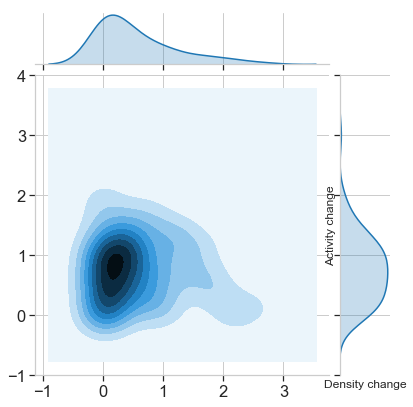

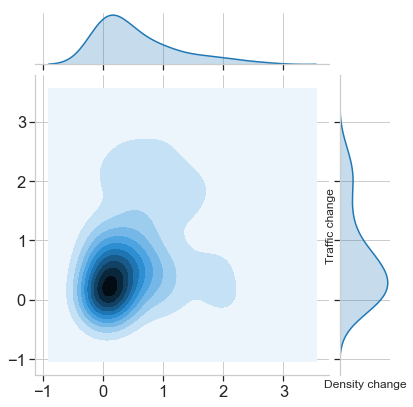

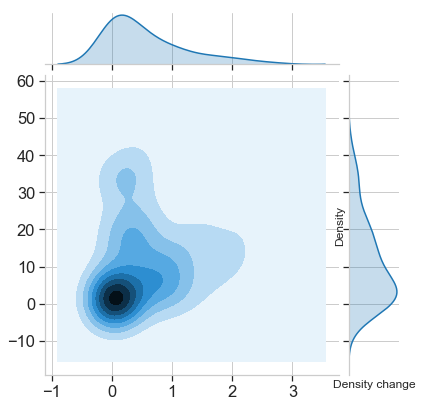

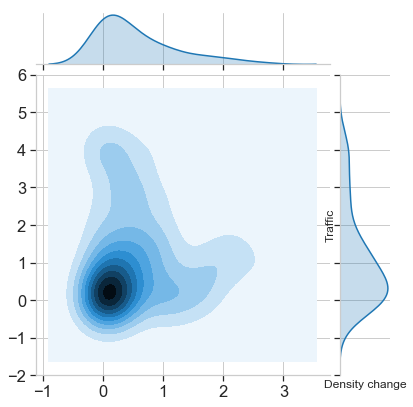

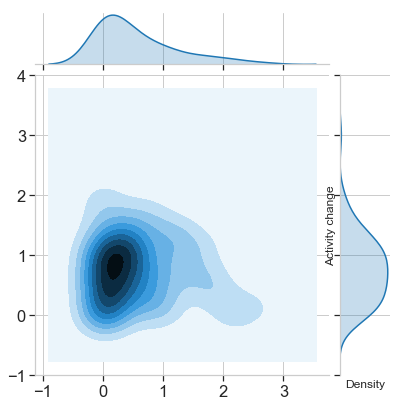

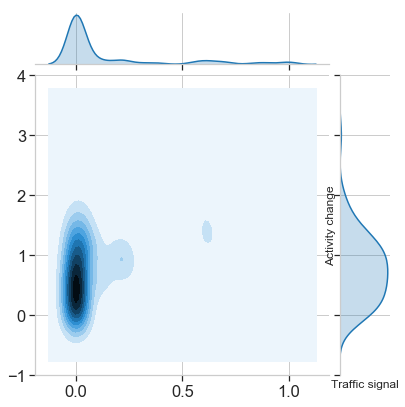

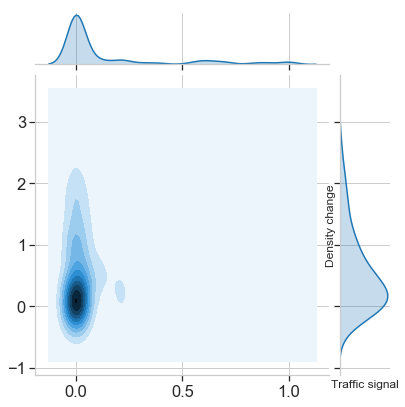

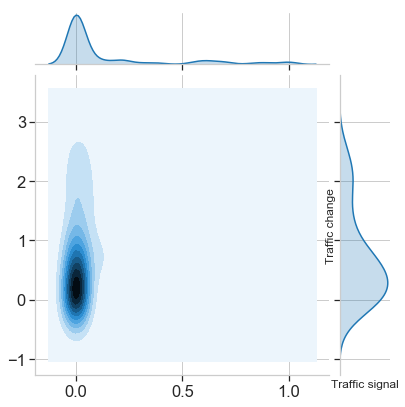

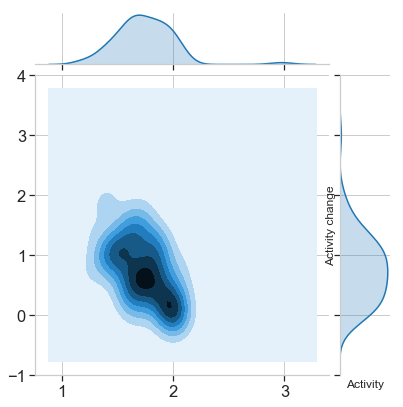

In [231]:
make_joinplots_for_pairs_of_parameters_for_clusters(cluster_df, 'Sum of EDR amplitudes_change')

Printing stats for:  Sum of EDR amplitudes
---
cluster label: 0
Activity: 1.759880538060215
Activity change: 0.5562620937957412
Traffic: 1.3519682500839973
Traffic_change: 0.6241455605856683
Density: 10.454426256411452
Density_change: 0.4771478241363841
---
cluster label: 1
Activity: 1.9076914452292857
Activity change: 0.5050454086781029
Traffic: 1.567003027245207
Traffic_change: 0.727547931382442
Density: 6.5564076690211905
Density_change: 0.5042381432896065
---
cluster label: 2
Activity: 1.8218992248062016
Activity change: 0.6486434108527133
Traffic: 1.3472868217054264
Traffic_change: 1.0424418604651162
Density: 6.099418604651163
Density_change: 0.4255813953488372
---
cluster label: 3
Activity: 1.3587301587301586
Activity change: 0.915873015873016
Traffic: 0.5873015873015873
Traffic_change: 0.5682539682539682
Density: 14.32063492063492
Density_change: 0.7365079365079364
---
cluster label: 4
Activity: 1.9417910447761193
Activity change: 0.09104477611940298
Traffic: 0.06119402985074626

c:\users\12974539\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


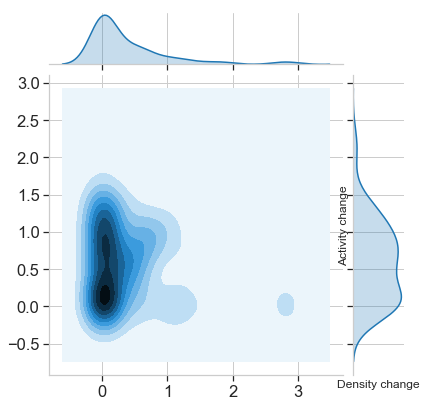

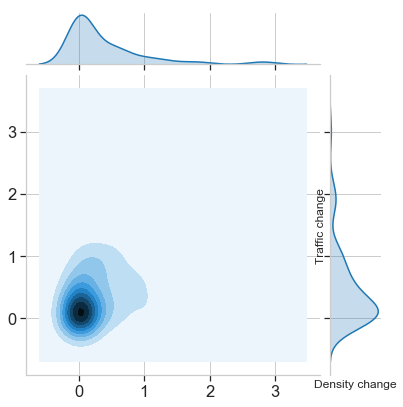

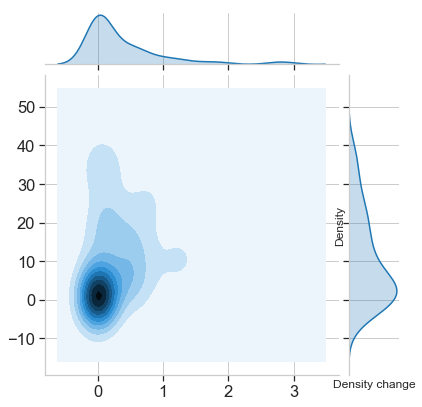

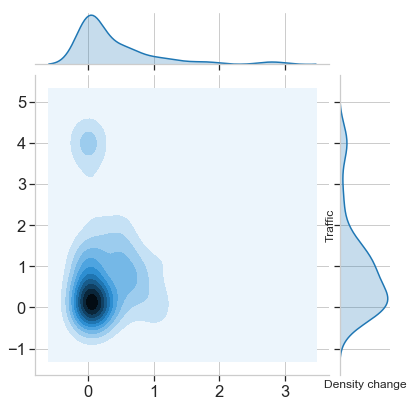

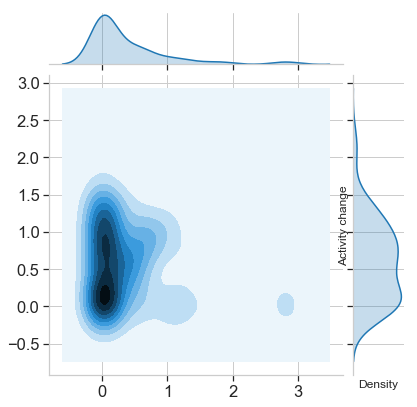

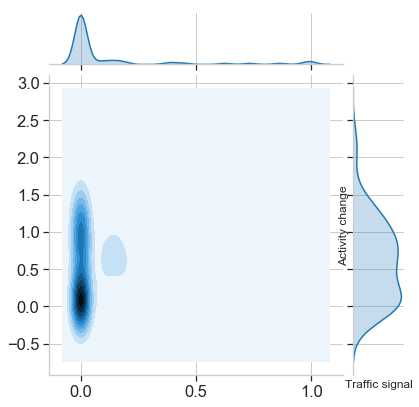

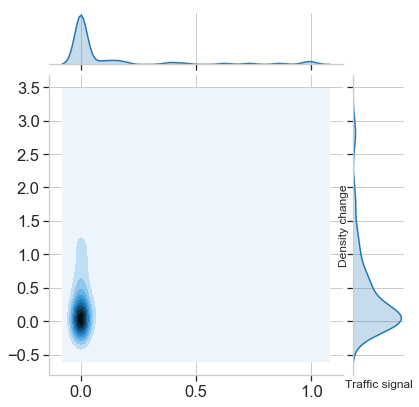

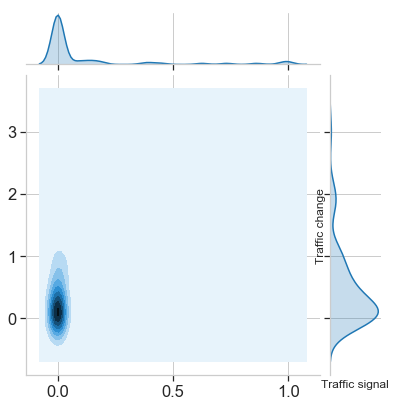

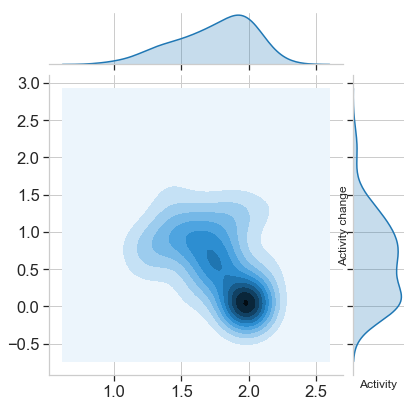

In [232]:
make_joinplots_for_pairs_of_parameters_for_clusters(cluster_df, 'Sum of EDR amplitudes')

# Definitions for making bar plots that visualise the distribution of the contextual/movement-related parameters for each cluster

In [233]:
def create_helper_df_for_visualising_parameters_for_each_cluster(this_df, target_signal):
    
    #cluster_col_name is 'this_lbl'
    #df_for_visualisations is 'density_plots'
    cluster_col_name = target_signal + '_cluster_label'
    user_col_name = 'Number of users_' + target_signal

    df_for_visualisations = this_df[this_df[cluster_col_name]>0].copy()

    # make a list with the columns containing parameters that we want to  visualise
    # These parameters are the stressors that may affect physiological responses 
    # We can add here any other parameter that we want to visualise for each cluster
    not_to_drop = ['Significant Changes:Activity', 'activity', 'Traffic', 'Significant Changes:Traffic',
            'Significant Changes:Density', 'Traffic signal','UserID',
            'Density', cluster_col_name, 'Sum of EDR amplitudes', 'Sum of EDR amplitudes_change_after_cutoff']


    # Drop all the columns that we do not want to visualise 
    for col in df_for_visualisations.columns:
        if col not in not_to_drop:
            df_for_visualisations = df_for_visualisations.drop(col, axis=1)
            
    # Also create one column with the changes in all parameters, in case we want to visualise that
    df_for_visualisations['all']=df_for_visualisations['Significant Changes:Density']+df_for_visualisations['Significant Changes:Traffic']+df_for_visualisations['Significant Changes:Activity']
    df_for_visualisations['Users in cluster']=this_df[user_col_name].copy()
    # Here we can keep only the clusters with more than X users by activating the following line (with any number in place of 3)
    #df_for_visualisations = df_for_visualisations[df_for_visualisations['Users in cluster']>=3]

    
    return(df_for_visualisations)

In [248]:
# This definition will plot all the values for each column on top of each other
# i.e. for each cluster, plot all the 'activity' values on top of each other in the designated bar for this cluster

def visualise_parameters_for_each_cluster(df_for_visualisations, target_signal, parameter, 
                                          this_fig_path, this_figure_size, save_this_figure):
    
    cluster_label = target_signal + '_cluster_label'
    
    plt.figure(figsize=this_figure_size)
    ax = sns.barplot(x=df_for_visualisations[cluster_label].to_list(), y=df_for_visualisations[parameter].to_list(), hue=df_for_visualisations[parameter].to_list(), dodge=False,
                     palette="GnBu_d", 
                      ci=None, data=df_for_visualisations, alpha=0.3)
    ax.legend_.remove()
    plt.xlabel('Cluster ID')
    plt.ylabel(parameter)
    plt.xticks(rotation=90)
    if save_this_figure==True:
        if ':' in parameter:
            parameter = parameter.replace(':','-')
        fig_path = this_fig_path.replace('this_img',parameter)
        
        plt.savefig(fig_path)

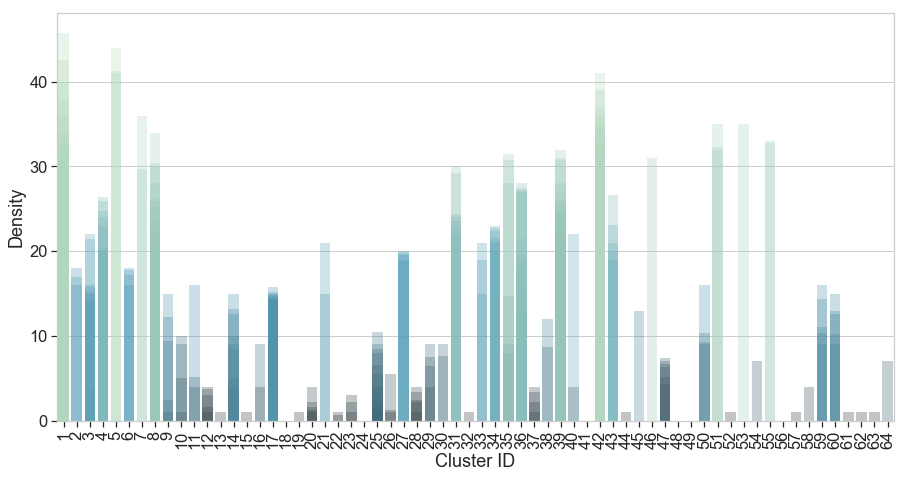

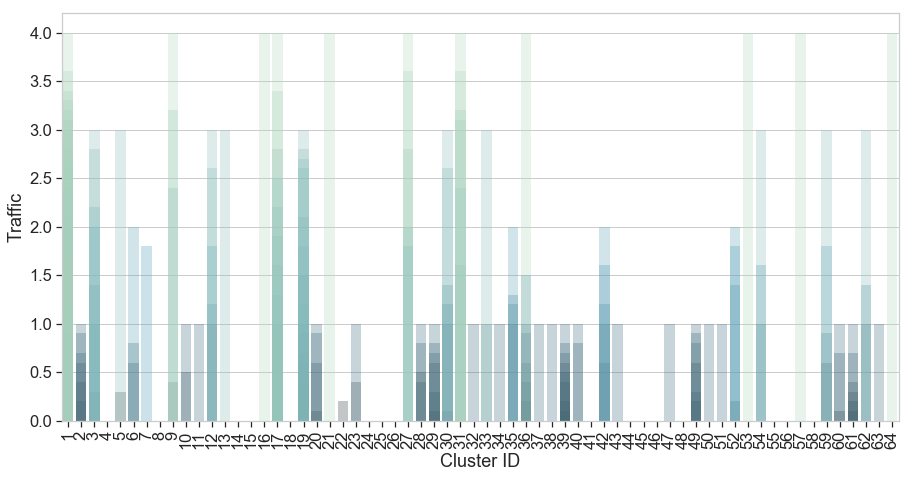

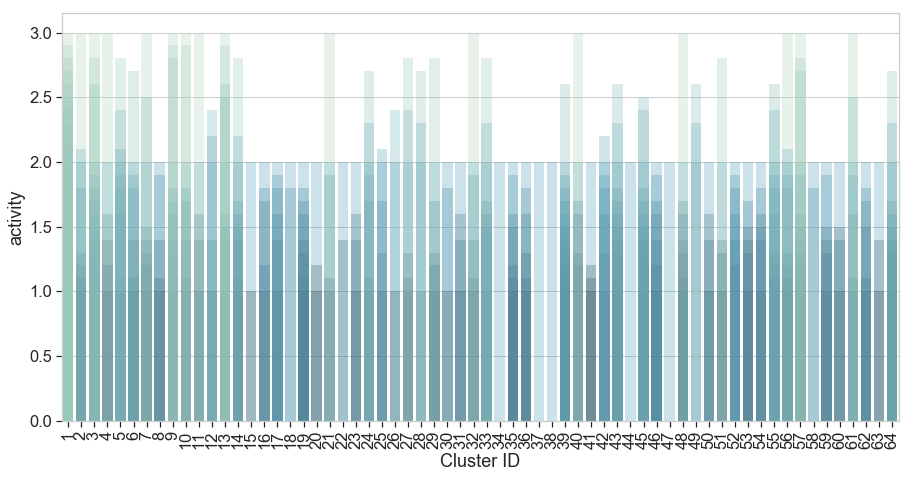

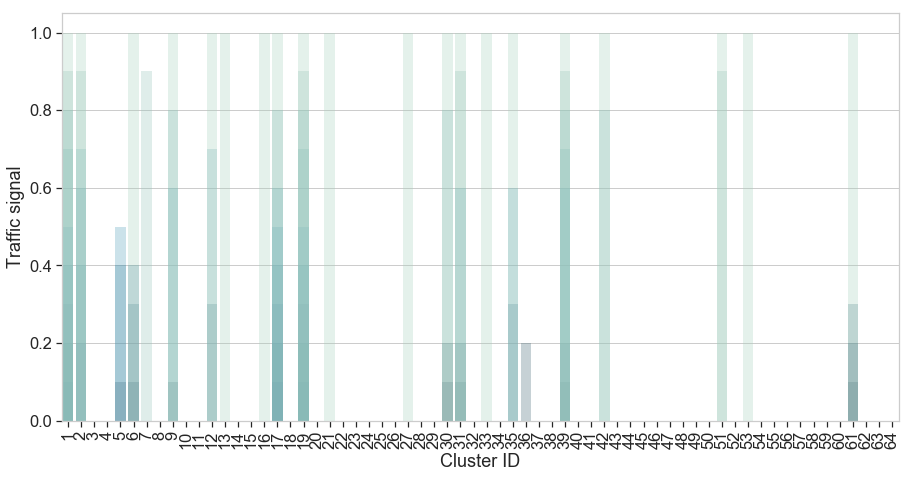

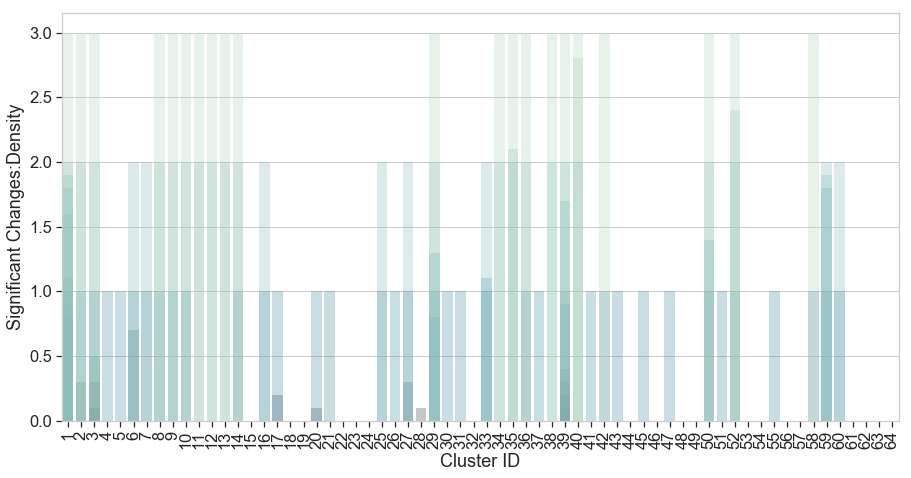

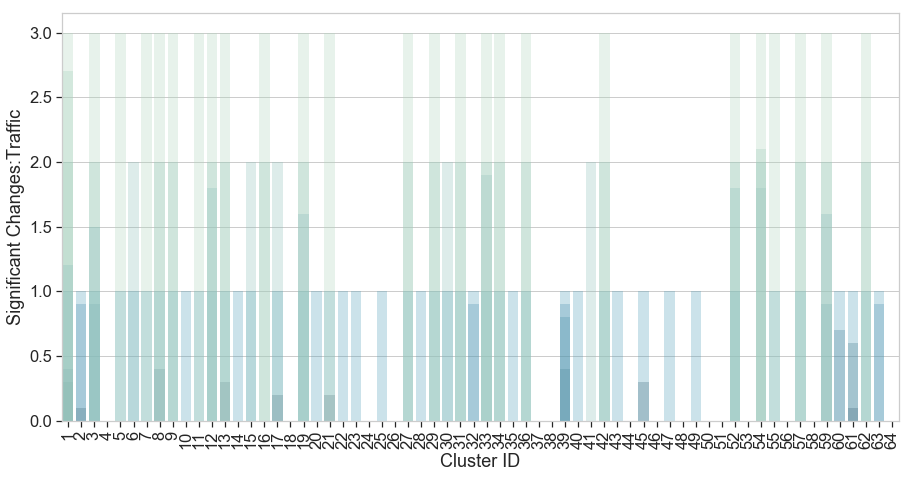

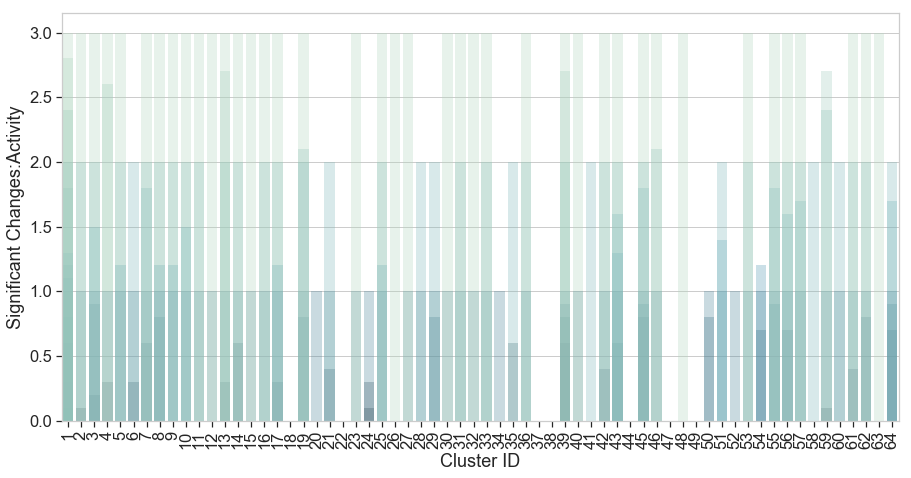

In [249]:
# The following line controls the scale of the plot 
sns.set_context("notebook", font_scale=1.5)
# Use the definition to create a df that only contains the clusters for visualisation
vis_df = create_helper_df_for_visualising_parameters_for_each_cluster(cluster_df, 'Sum of EDR amplitudes_change')
# This is the path where the graphs from the analysis will be saved. Replace with the desired path
test_path = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Cluster analysis images\Sum of EDR amplitudes_change\this_img.png'
# which parameters to visualise
parameters_to_visualise = ['Density','Traffic','activity','Traffic signal','Significant Changes:Density',
                          'Significant Changes:Traffic','Significant Changes:Activity']
for p in parameters_to_visualise:
    #print(p)
    visualise_parameters_for_each_cluster(vis_df,'Sum of EDR amplitudes_change',p,test_path,(15,7.5),False)
# To save the graphs in the path defined above, change 'False' to 'True' in the line above


#### Plot graphs with the mean value for each column

In [241]:
def create_df_with_mean_parameters_for_each_cluster(df_for_visualisations, target_signal, parameters_for_visualisation):
    
    df_with_mean_parameters = pd.DataFrame(columns=parameters_for_visualisation)
    cluster_col_name = target_signal + '_cluster_label'
    # Find the mean value of each parameter, for each cluster       
    for i in df_for_visualisations[cluster_col_name].unique():
        for bar in parameters_for_visualisation:
            this_cluster = df_for_visualisations[df_for_visualisations[cluster_col_name]==i]
            df_with_mean_parameters.loc[i, bar]=this_cluster[bar].mean()
            df_with_mean_parameters.loc[i, 'Index']= int(i)
            df_with_mean_parameters['Index']=df_with_mean_parameters['Index'].astype(int)
    return(df_with_mean_parameters)

In [242]:
parameter_list = ['Density','activity','Traffic','Significant Changes:Activity','Significant Changes:Density',
             'Significant Changes:Traffic','Traffic signal']
df_with_means = create_df_with_mean_parameters_for_each_cluster(vis_df, 'Sum of EDR amplitudes_change',parameter_list)
df_with_means

,Density,activity,Traffic,Significant Changes:Activity,Significant Changes:Density,Significant Changes:Traffic,Traffic signal,Index
1,8.21516,1.70692,1.38342,0.590539,0.631638,0.896033,0.114242,1
2,17.0405,1.90946,0.870946,0.331757,0.184459,0.168919,0.843919,2
9,2.36957,1.85217,0.391304,1.0913,1.3913,1.91304,0.0978261,9
3,17.3455,1.69773,1.69318,0.504545,0.302273,0.775758,0,3
4,20.0408,2.97388,0,0.0246281,0.00826446,0,0,4
5,42.3312,1.78125,1.33125,1.2,0.5,1.4375,0.0625,5
42,36.0289,1.51111,0.555556,1.05333,0.222222,0.666667,0.04,42
6,16.5,1.62778,0.855556,0.183333,0.65,0.666667,0.322222,6
7,35.85,1.37857,0.0428571,1.03333,0.404762,0.571429,0.0214286,7
8,25.1207,1.6,0,0.758621,1.44828,1.28966,0,8


In [ ]:
def visualise_mean_parameters_for_each_cluster(df_with_mean_parameters,target_signal, this_parameter,
                                               this_fig_path,this_figure_size, save_this_figure):
    plt.figure(figsize=this_figure_size)
    ax = sns.barplot(x='Index', y=df_with_mean_parameters[this_parameter].to_list(), hue=df_with_mean_parameters[this_parameter].to_list(), dodge=False,
                     palette="GnBu_d", data = df_with_mean_parameters,
                      ci=None,  alpha=0.6)
    ax.legend_.remove()
    plt.xlabel('Cluster ID')
    plt.ylabel(this_parameter)
    plt.xticks(rotation=90)
    plt.title('Cluster analysis for ' + target_signal + ' signal: Mean values for ' + this_parameter)
    if save_this_figure==True:
        if ':' in this_parameter:
            this_parameter = this_parameter.replace(':','-')
        this_fig_path = this_fig_path.replace('this_img',this_parameter + '_mean values for each cluster')
        plt.savefig(this_fig_path)

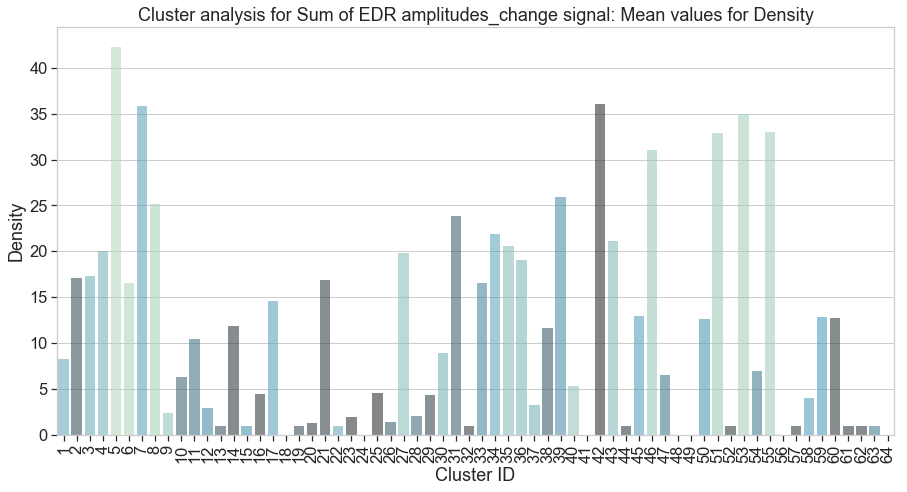

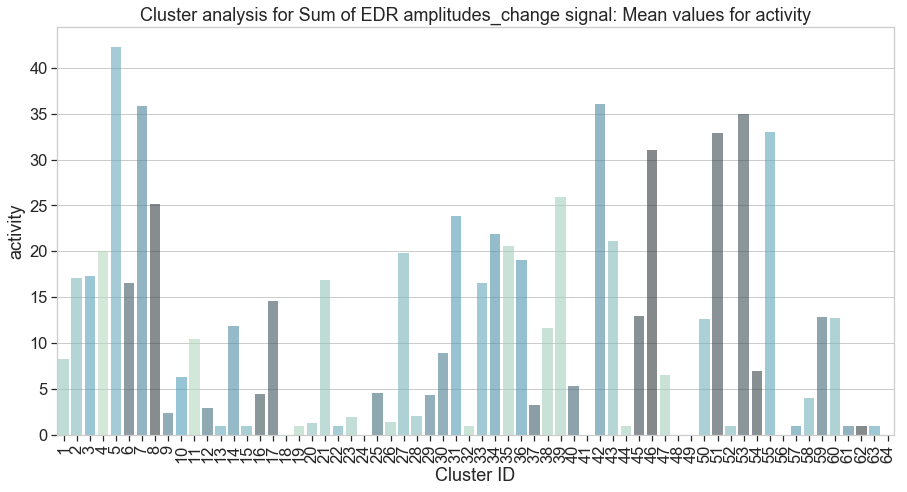

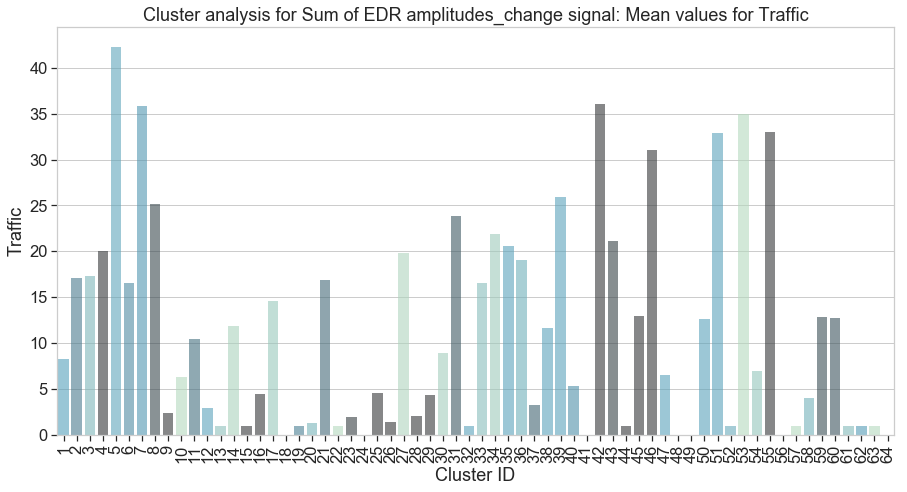

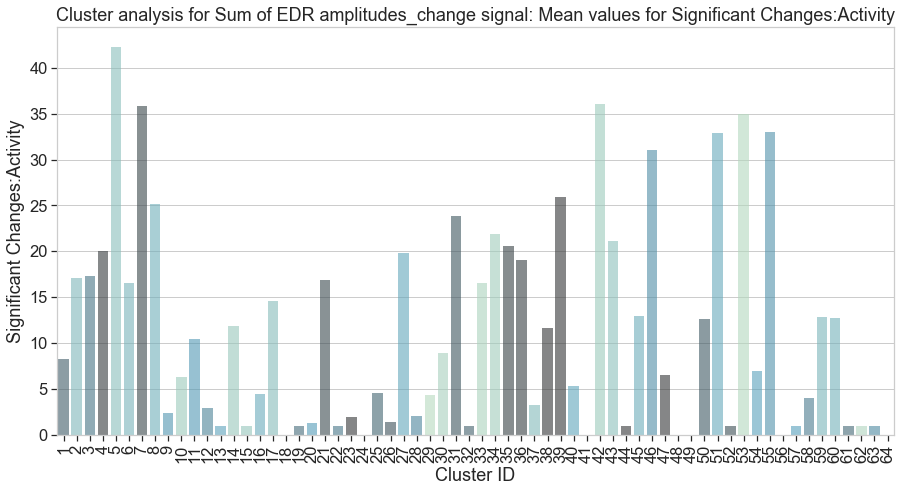

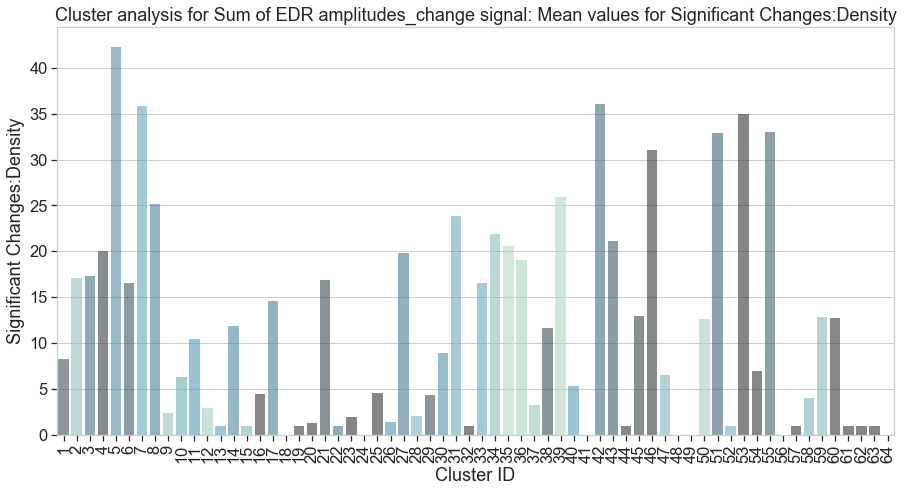

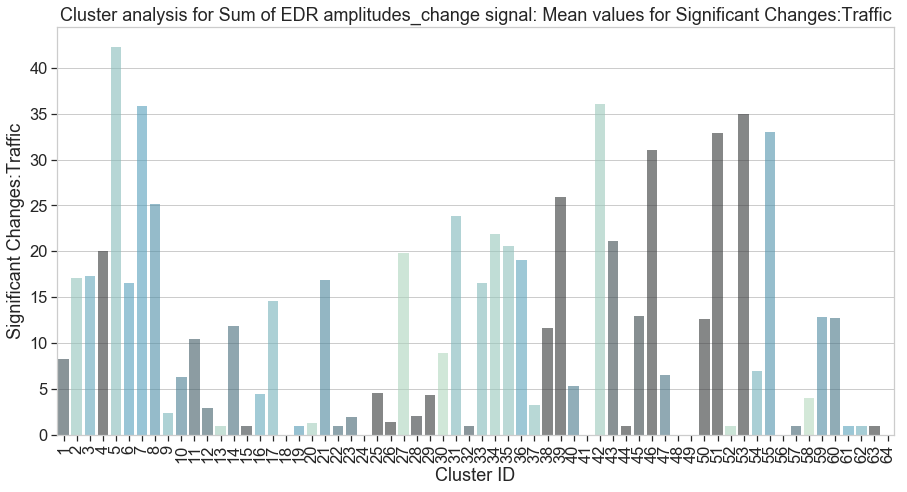

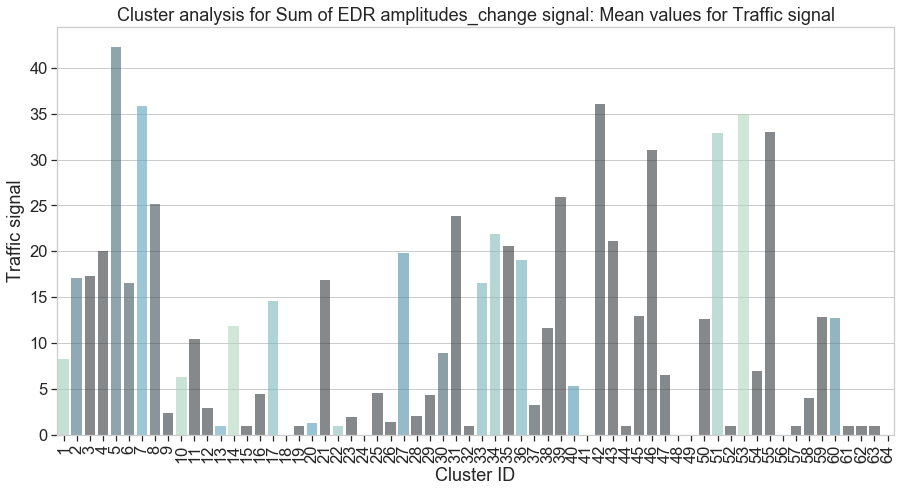

In [245]:
# Path for saving the figures. Replace with the desired path
fig_path_for_mean_values = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Cluster analysis images\Sum of EDR amplitudes_change\this_img_mean_values.png'

for p in parameter_list:
    visualise_mean_parameters_for_each_cluster(df_with_means,'Sum of EDR amplitudes_change',p,
                                                   fig_path_for_mean_values,(15,7.5),False)
# To save the graphs in the path defined above, change 'False' to 'True' in the line above
